### High-Frequency Data Analysis and Market Microstructure

시장의 미시 구조적 기본 특성에 대해 알아보고 분석해본다

#### 1. Price Sequences

**1.1 Tick Rules**

틱 규칙이란 거래에 있어서 공격적 거래자의 방향(aggressor side)을 결정하기 위한 알고리즘이다. 다음 논리에 따라서 매수가 주도한 거래는 1, 매도가 주도한 거래가 -1로 labeling을 한다

$$b_t = \begin{cases}
1, ~~ & \mbox{if } \Delta p_t > 0\\
-1, ~~ & \mbox{if } \Delta p_t < 0\\
b_{t-1}, ~~ & \mbox{if } \Delta p_t = 0
\end{cases}$$

여기서 $p_t$는 $t=1,\cdots, T$로 인덱스된 거래 가격이고, $b_0$은 임의로 1로 설정된다. 여러 연구를 통해 틱 규칙은 상대적으로 단순함에도 불구하고 높은 분류 정확도를 가진다.

$\{b_t\}$ 계열의 변환은 정보성 특성을 만들어낼 수 있다. 이런 변환에는 다음과 같은 것들이 있다.

1. 미래 기대값 $E_t[b_{t+1}]$에 대한 Kalman Filter
2. 이런 예측에 대한 구조적 변화
3. $\{b_t\}$ sequence의 Entropy
4. $\{b_t\}$ 런에 대한 Wald-Wolfowitz 테스트로부터의 t값
5. 누적 $\{b_t\}$계열 $\sum_{t=1}^t b_t$의 fractionallly diffrentiated features

#### example 1

공격적 거래자의 방향을 labeling하는 것을 Tick Rule이라 한다. 이를 `clean_IVE_fut_prices.parq`에 대해 적용해 보자. 자료는 Notion Data Base에서 구할 수 있다. 

`clean_IVE_fut_prices.parq`는 iShare S&P500 mini ETF 가격 시계열 데이터이며, 2009년 9월 28일부터 2018년 10월 5일까지의 bid-ask 데이터가 기록되어 있다

- price : 종가
- bid : 매수가
- ask : 매도가
- size : 집행 크기
- v : volume 즉 거래량
- dv : dollar value, 총 거래금액

parq 확장자의 파일을 불러오기 위해서는 `pyarrow`와 `fastparquet` 라이브러리 설치가 필요하다

In [1]:
import numpy as np
import pandas as pd
import MicroStructure as ms

futures = pd.read_parquet('clean_IVE_fut_prices.parq')
futures.head()

,price,bid,ask,size,v,dv
dates,,,,,,
2009-09-28 09:30:00,50.79,50.70,50.79,100,100,5079.00
2009-09-28 09:30:00,50.71,50.70,50.79,638,638,32352.98
2009-09-28 09:31:32,50.75,50.75,50.76,100,100,5075.00
2009-09-28 09:31:33,50.75,50.72,50.75,100,100,5075.00
2009-09-28 09:31:50,50.75,50.73,50.76,300,300,15225.00


`MicroStructure.py` 내의 `tick_rule()`함수를 활용해 tick rule을 적용 가능하다

In [2]:
ms.tick_rule(futures.price).head()

dates
2009-09-28 09:30:00    1.0
2009-09-28 09:30:00   -1.0
2009-09-28 09:31:32    1.0
2009-09-28 09:31:33    1.0
2009-09-28 09:31:50    1.0
dtype: float64

함수의 구조를 보면 알겠지만, 가격이 전날에 비해 상승하였으면 1, 하락하였으면 -1로 labeling한다.

**1.2 The Roll Model**

추세가 없는 Random walk를 따르는 중간 가격 계열 $\{m_t\}$를 고려해 보자
$$m_t = m_{t-1} + u_t$$

따라서 가격 변화 $\Delta m_t = m_t - m_{t-1}$는 다음의 정규 분포로부터 독립적이고 동일하게 추출된다

$$\Delta m_t \sim N(0, \sigma_u^2)$$

이러한 가정은 금융 시계열이 추세를 가지고, 이분산적이고, 상관관계를 보이고, 수익률 분포가 비정규 분포라는 모든 경험적 관찰에 상반된다. 관측된 가격 $\{p_t\}$는 매매 호가 스프레드에 대한 순차적 거래의 결과이다

$$p_t = m_t + b_tc$$

여기서 c는 매매 호가 스프레드의 절반이고 $b_t \in \{-1, 1\}$은 공격적 거래자의 방향이다. Roll model은 매수와 매도가 발생활 확률이 동일하고, 잡음으로부터의 독립이라고 가정한다. 이런 가정 하에서 롤은 $c$와 $\sigma_u^2$값을 다음과 같이 도출한다

$$\sigma^2[\Delta p_t] = E[(\Delta p_t)^2] - (E[\Delta p_t])^2 = 2c^2 + \sigma_u^2$$
$$\sigma[\Delta p_t, \Delta p_{t-1}] = -c^2$$

이는 $c = \sqrt{\max\{0, -\sigma[\Delta p_t, \Delta p_{t-1}] \}}$와 $\sigma_u^2 = \sigma^2[\Delta p_t] + 2\sigma[\Delta p_t, \Delta p_{t-1}]$의 결과를 갖게 한다. 결론적으로 매매 호가 스프레드는 가격 변화의 계열 공분산 함수이고, 미시 구조적 잡음을 제거한 참 가격의 잡음은 관측된 잡음과 가격 변화의 계열 공분산의 함수이다

Roll model에서 추정된 스프레드를 활용해 거래시 발생하는 비용과 위험을 추정할 수 있다

#### example 2

Roll Model을 `clean_IVE_fut_prices.parq`에 대해 적용해 보자. `MicroStructure.py`내의 `RollModel()` Class를 instance화 해 주면 사용 가능하다. initialize 필요한 정보는 다음과 같다.

- close_prices : 가격 시계열
- window : measure와 impact 추정시 사용될 기간의 값. 기본값은 20이다

In [3]:
roll_model = ms.RollModel(close_prices = futures.price, window = 20) # instance

`roll_measure()` method 사용하면 매매호가 스프레드를 추정 가능하다

In [4]:
measure = roll_model.roll_measure().dropna()
measure.head()

dates
2009-09-28 09:37:29    0.031304
2009-09-28 09:37:29    0.018340
2009-09-28 09:37:33    0.017725
2009-09-28 09:38:28    0.018635
2009-09-28 09:38:32    0.018294
Name: price, dtype: float64

Text(0.5, 1.0, 'The Roll Model')

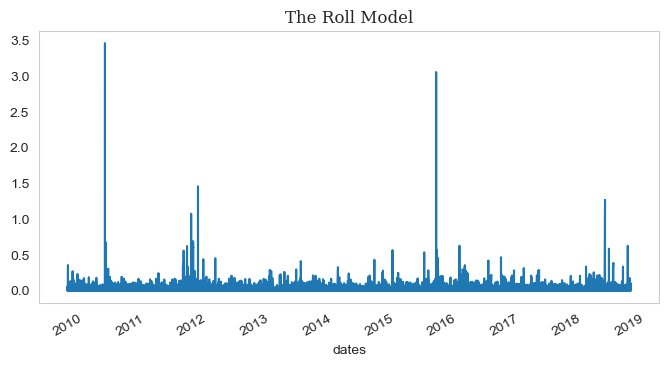

In [5]:
import matplotlib.pyplot as plt
measure.plot(grid = False, figsize = (8, 4))
plt.title("The Roll Model", fontsize = 12, fontfamily = 'Serif')

`roll_impact()` method를 사용하여 roll 효과를 추정할 수 있다. 이 효과는 주식을 매매할 때 발생하는 추가적인 비용이나 영향을 나타낸다 (즉, 거래 비용이다)
 
이 비용은 시장에서 큰 규모로 거래할 때 발생할 수 있는 슬리피지(slippage)나 시장 내외적인 요인들로 인해 발생한다

In [6]:
impact = roll_model.roll_impact(futures.dv).dropna()
impact.head()

dates
2009-09-28 09:37:29    0.000002
2009-09-28 09:37:29    0.000001
2009-09-28 09:37:33    0.000002
2009-09-28 09:38:28    0.000002
2009-09-28 09:38:32    0.000001
dtype: float64

Text(0.5, 1.0, 'The Roll Impact')

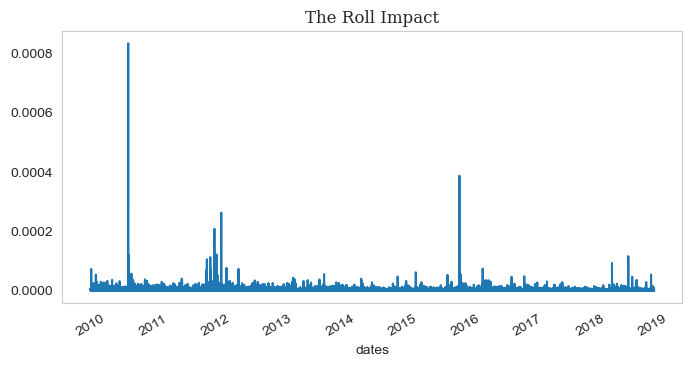

In [7]:
impact.plot(grid = False, figsize = (8, 4))
plt.title("The Roll Impact", fontsize = 12, fontfamily = 'Serif')

종합해 볼 때, 위기가 발생할 때에는 유동성위험 및 매수매도 스프레드가 벌어지기 때문에 거래비용이 높아지는 것으로 해석할 수 있다

**1.3 Corwin and Schultz**

Corwin, Schultz는 매매 호가 스프레드를 가격의 퍼센티지로 다음과 같이 계산할 수 있다는 것을 보였다

$$S_t = \frac{2(e^{\alpha_t}-1)}{1+e^{\alpha_t}}$$

여기서

$$\alpha_t = \frac{\sqrt{2\beta_t} - \sqrt{\beta_t}}{3 - 2\sqrt{2}} - \sqrt{\frac{\gamma_t}{3-2\sqrt{2}}}$$
$$\beta_t = E \Big[\sum_{j=0}^1 \Big[\log \Big(\frac{H_{t-j}}{L_{t-j}} \Big) \Big]^2\Big]$$
$$\gamma_t = \Big[\log \Big(\frac{H_{t-1, t}}{L_{t-1, t}}\Big) \Big]^2$$

$H_{t-1,t}$는 두 기간에 걸친 고가이고, $L_{t-1,t}$는 두 기간에 걸친 저가이다. Corwin-Schultz의 식에서는 변동성이 보이지 않는데, 이는 고가/저가 추정량으로 대체되었기 때문이다. 이 모델로써 벡커-파킨슨 변동성을 유도할 수 있다

#### example 3

Corwin Schultz Spread를 `clean_IVE_fut_prices.parq`에 대해 추정해 보자. class `CorwinSchultz()`를 사용하면 corwin schultz 모형을 추정할 수 있다

initializer로는 low와 high에 대한 데이터가 필요하다

In [8]:
spread = ms.CorwinSchultz(high = futures.ask, low = futures.bid)

`corwin_schultz_extimator()` method를 사용하면 쉽게 스프레드 추정량을 계산할 수 있다

In [9]:
cs_estimator = spread.corwin_schultz_estimator(window = 20)
cs_estimator.dropna().head()

/Users/junghunlee/anaconda3/envs/TimeSeriesModeling/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


dates
2009-09-28 09:37:22    0.000763
2009-09-28 09:37:29    0.000319
2009-09-28 09:37:29    0.000078
2009-09-28 09:37:33    0.000000
2009-09-28 09:38:28    0.000000
Name: Spread, dtype: float64

Text(0.5, 1.0, 'Corwin Schultz Spread Estimator')

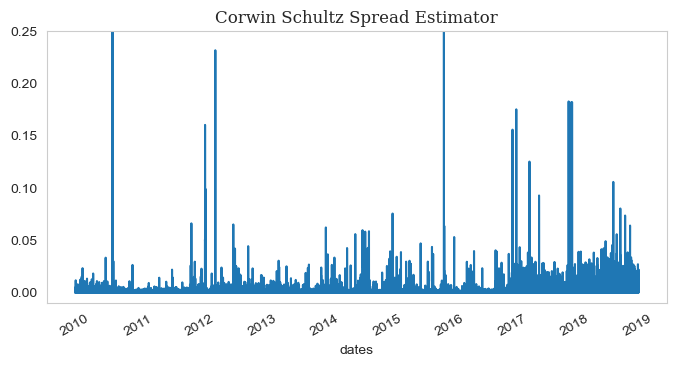

In [10]:
cs_estimator.dropna().plot(grid = False, figsize = (8, 4))
plt.ylim([-0.01, 0.25])
plt.title("Corwin Schultz Spread Estimator", fontsize = 12, fontfamily = 'Serif')

**1.4 High-Low Volatility Estimator**

Parkinson(1980)은 기하 브라운 운동을 따르는 연속적으로 관측되는 가격에 대해 다음을 유도했다

$$E\Big[ \frac{1}{T} \sum_{t=1}^T \Big( \log\Big[\frac{H_t}{L_t}\Big]\Big)\Big] = k_1\sigma_{HL}^2$$
$$E\Big[ \frac{1}{T} \sum_{t=1}^T \Big( \log\Big[\frac{H_t}{L_t}\Big]\Big)\Big] = k_2\sigma_{HL}$$

여기서 $k_1 = 4\log(2), k_1 = \sqrt{\frac{8}{\pi}}$, $H_t$는 바 t에 대한 고가이고, $L_t$는 바 t에 대한 저가이다. 그러면 변동성 특성 $\sigma_{HL}$은 관측된 고가-저가에 기초해 안정적으로 계산 가능하다

#### example 4

example 3에서 추정한 corwin schultz spread를 이용해 becker parkinson volatility를 추정해 보자

instance화된 변수에 `becker_parkinson_vol()` method를 사용하면 쉽게 추정이 가능하다. window의 기본값은 20이다

In [11]:
bp_vol = spread.becker_parkinson_vol(window = 20)
bp_vol.dropna().head()

/Users/junghunlee/anaconda3/envs/TimeSeriesModeling/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


dates
2009-09-28 09:37:22    0.000000
2009-09-28 09:37:29    0.000120
2009-09-28 09:37:29    0.000227
2009-09-28 09:37:33    0.000512
2009-09-28 09:38:28    0.000520
dtype: float64

Text(0.5, 1.0, 'Becker Parkinson Volatility Estimator')

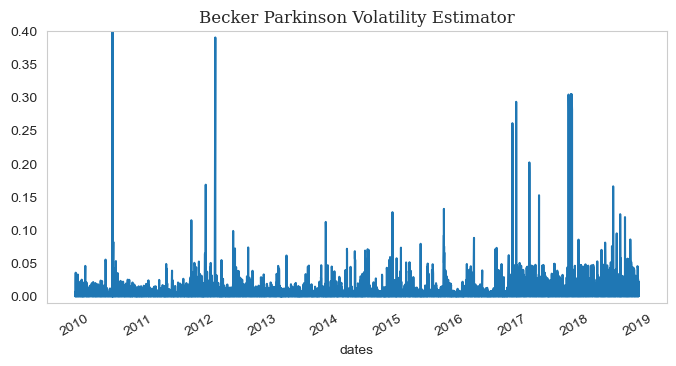

In [12]:
bp_vol.dropna().plot(grid = False, figsize = (8, 4))
plt.ylim([-0.01, 0.4])
plt.title("Becker Parkinson Volatility Estimator", fontsize = 12, fontfamily = 'Serif')

#### Exercise 1

위 모형들은 시장미시구조에서 사용되는 모형들이지만, Daily Data에 대해서도 얼마든지 사용할 수 있다. SK Hynics에 대해 2018년 01월 01일부터 2023년 10월 25일까지의 데이터를 import하여 다음을 수행하라

In [13]:
import pandas_datareader as pdr

1.1 종가 가격 계열에 대해서 Tick Rule을 적용하라

In [14]:
# Write your code here

1.2 종가 가격 계열에 대해서 Roll Model을 적용하라. roll impact로 추정한 거래 비용은 얼마인가?

In [15]:
# Write your code here

1.3 SK Hynics high-low price를 사용하여 Corwin Schultz Spread를 추정하라

In [16]:
# Write your code here

1.4 1.3번 문제에서 추정한 spread를 이용해 Becker Parkinson Volatility를 추정하라

In [17]:
# Write your code here

#### 2. Bar Sampling

<center><img src = "https://janhove.github.io/posts/2019-04-11-assumptions-relevance/index_files/figure-html/unnamed-chunk-2-1.png" alt="My Image"></center>

OLS Regression을 다시한 번 생각해 보자. 설명변수인 Feature는 정규분포를 따라야 하고 오차항 또한 정규분포를 따라야 한다. 설명변수와 오차항은 서로 독립이어야 한다. 이러한 정규성은 횡단면 자료 분석 뿐만 아니라 시계열 분석에서도 요구되어진다

그러나, 우리가 보는 데이터의 대부분은 정규성 가정에는 거리가 먼 경우가 대부분이다. 대부분의 통계 모형은 정규성이 지켜진다는 가정 하에 세워진 이론이지만, 대부분의 데이터는 이러한 가정이 지켜지지 않아 편향과 오차가 심하게 생길수 밖에 없다

추정과 Machine Learning에서의 예측을 위해 Bar Sampling을 통계학 가정에 좀 더 가까운 형태로 변환하는 Sample 추출 방법에 대해 알아보자

**2.1 Time Bar**

대부분의 python library에서 제공하는 바의 형태는 time bar이다. 이러한 바를 이용함으로써 얻는 정보는 다음과 같다

- Timestamp
- 거래량 가중 평균가
- Open Price
- Close Price
- High Price
- Low Price
- Volume

이러한 time bar는 얻기 쉬운 데이터이지만, 아래와 같은 치명적인 단점을 가지고 있다

1. 시장은 정보를 일정한 시간 간격으로 처리하지 않기 때문에, 일정한 시간 간격으로 추출된 바는 정보의 양이 일정하지 않다
2. 시간에 추출된 바는 좋지 않은 통계적 성질을 보인다

금융시장은 대개 미수주문이 처리되는 개장 직후 30분간의 정보와 폐장 직전 1시간 가량의 정보가 가장 많고, 점심시간인 오후 12시에서 1시 사이에는 정보의 양이 적다. 만약 일정한 시간마다 bar를 추출할 경우 점심시간과 개장 및 폐장 시기의 정보의 양에 차이가 발생할 것이다

In [29]:
futures.head() # time bar

,price,bid,ask,size,v,dv
dates,,,,,,
2009-09-28 09:30:00,50.79,50.70,50.79,100,100,5079.00
2009-09-28 09:30:00,50.71,50.70,50.79,638,638,32352.98
2009-09-28 09:31:32,50.75,50.75,50.76,100,100,5075.00
2009-09-28 09:31:33,50.75,50.72,50.75,100,100,5075.00
2009-09-28 09:31:50,50.75,50.73,50.76,300,300,15225.00


**2.2 Tick Bar**

tick bar의 기본적인 아이디어는 간단하다. 앞서 말한 변수들을 사전에 정해 둔 건수가 발생할 때마다 추출하는 것이다. 이렇게 하면 정보의 도착과 표본의 추출을 동기화할 수 있다

Mandelbrot과 Taylor는 표본 추출을 거래 건수에 대한 함수로 수행하면 표본이 바람직한 통계적 성질을 가진다는 것을 처음으로 발견한 사람 중 하나이다. 이들의 발견 이후, 다수의 연구에서 거래 활동에 관한 함수로 표본을 추출하면 IID 정규 분포에 근접한 수익률을 얻을 수 있다는 것이 확인되었다. 대다수의 통계 모형과 기계학습 모형이 표본을 IID로 가정하고 추정되므로 이는 매우 중요한 성질 중 하나이다. 따라서, Tick Bar는 Time Bar에 비해 더 좋은 통계적 추론이 가능하다.

`MicroStructure.py`의 `BarSampling()`함수를 사용해서 Sampling을 할 수 있다. threshold를 조정하여 추출 빈도수를 조정할 수 있다

In [21]:
tick = ms.BarSampling(futures, 'price', threshold = 100, tick = True).dropna()
tick.head() # tick bar

,price,bid,ask,size,v,dv
dates,,,,,,
2009-09-28 09:53:14,51.1500,51.15,51.18,100,100,5115.00
2009-09-28 10:02:52,51.2500,51.24,51.26,2000,2000,102500.00
2009-09-28 10:22:24,51.1961,51.19,51.20,1100,1100,56315.71
2009-09-28 10:38:44,51.3650,51.36,51.36,100,100,5136.50
2009-09-28 11:24:29,51.3200,51.32,51.33,2000,2000,102640.00


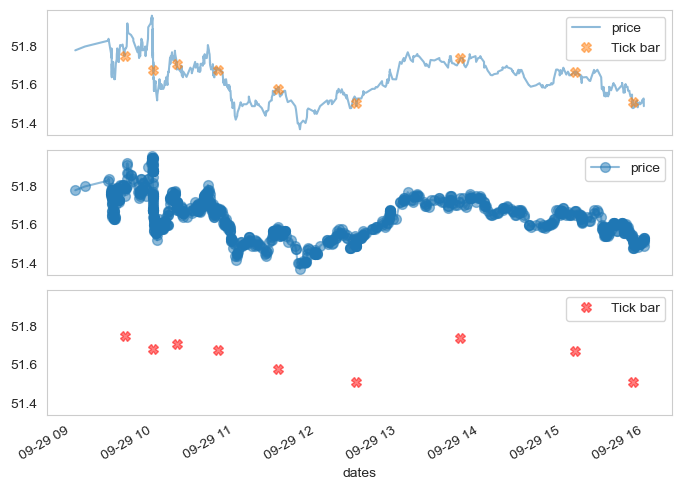

In [22]:
xDate = '2009-09-29'
xdf, xtdf = ms.select_sample_data(futures, tick, 'price', xDate)
ms.plotSampleData(xdf, xtdf, 'Tick bar', alpha = 0.5, markersize = 7)

**2.3 Volume Bar**

tick bar의 문제점 중 하나는 threshold가 주문의 파편성으로 임의적이라는 것이다. 

예를 들어, 크기가 10인 주문이 들어오면 그 거래는 하나의 틱으로 기록된다. 반면에 크기가 1인 주문이 10개가 쌓여 있다면 그 주문의 집합은 10개의 개별 주문으로 기록될 것이다. 

거래량 바는 임의로 정해진 tick의 개수가 아닌 volume에 의해 추출된다. 주문의 크기에 구애받지 않고 거래가 일정한 수에 도달할 때마다 표본을 추출할 수 있다. 

Clark는 Tick bar에 의해 추출된 샘플보다 Volume bar가 더 나은 통계적 성질을 가진다는 것을 알아 냈다

In [25]:
volume_M = 10000
volume = ms.BarSampling(futures, column = 'v', threshold = volume_M)
volume.head() # volume bar

,price,bid,ask,size,v,dv
dates,,,,,,
2009-09-28 09:44:09,50.91,50.91,50.92,1100,1100,56001.0
2009-09-28 09:46:35,51.07,51.05,51.07,3300,3300,168531.0
2009-09-28 09:52:47,51.13,51.13,51.14,2000,2000,102260.0
2009-09-28 09:54:36,51.13,51.11,51.13,400,400,20452.0
2009-09-28 09:54:41,51.14,51.13,51.14,700,700,35798.0


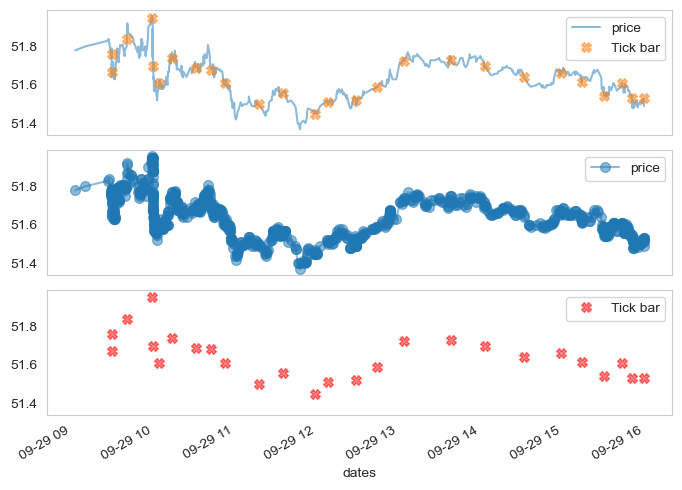

In [26]:
xDate = '2009-09-29'
xdf, xtdf = ms.select_sample_data(futures, volume, 'price', xDate)
ms.plotSampleData(xdf, xtdf, 'Tick bar', alpha = 0.5, markersize = 7)

**2.4 Dollar Value Bar**

Dollar value bar는 사전에 정해 둔 시장가치 (market value)가 거래될 때마다 관측값을 표본 추출하는 것이다. (굳이 달러 뿐만이 아니라 모든 화폐 단위에 적용 가능하다)

volume bar에 비해 액면분할 혹은 병합으로 인해 주식 수를 조정하는 경우의 주식 발행이나 자사주 매입과 같이 **기업의 재무 활동에 비해 강건한 경향**을 보이기 때문에 좋은 표본 추출 방법이다

In [27]:
dollar_M = 1000000
dollar = ms.BarSampling(futures, column = 'dv', threshold = dollar_M)
dollar.head() # dollar value bar

,price,bid,ask,size,v,dv
dates,,,,,,
2009-09-28 09:46:35,51.07,51.05,51.07,900,900,45963.0
2009-09-28 09:53:49,51.14,51.13,51.14,2000,2000,102280.0
2009-09-28 09:55:26,51.14,51.11,51.14,100,100,5114.0
2009-09-28 10:02:52,51.25,51.24,51.26,4300,4300,220375.0
2009-09-28 10:10:21,51.29,51.28,51.29,4500,4500,230805.0


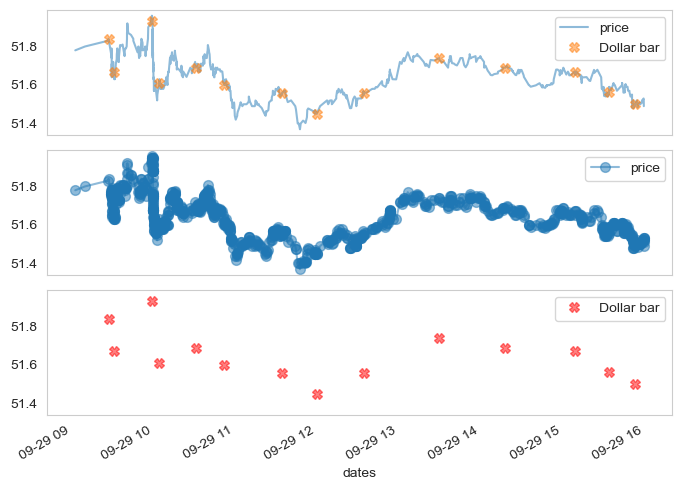

In [28]:
xdf, xtdf = ms.select_sample_data(futures, dollar, 'price', xDate)
ms.plotSampleData(xdf, xtdf, 'Dollar bar', alpha = 0.5, markersize = 7)

Sampling된 데이터의 통계적 특성에 대해 살펴보자

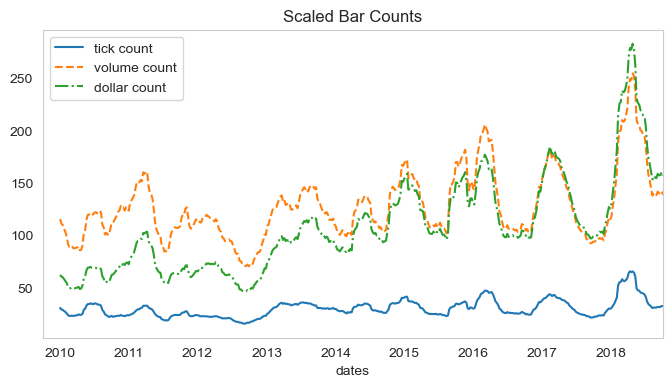

In [34]:
def count_bars(df, price_col = 'price'):
    return df.groupby(pd.Grouper(freq = '1W'))[price_col].count().rolling(14).mean()

tc = count_bars(tick)
vc = count_bars(volume)
dc = count_bars(dollar)
dfc = count_bars(futures)
ms.plot_bar_counts(tc, vc, dc)

Sampling Count는 Tick Bar가 가장 적고, Volume Bar가 가장 많이 나타나는 것으로 보인다

In [37]:
time_ret = np.log(futures.price / futures.price.shift()).dropna()
tick_ret = np.log(tick.price / tick.price.shift()).dropna()
volume_ret = np.log(volume.price / volume.price.shift()).dropna()
dollar_ret = np.log(dollar.price / dollar.price.shift()).dropna()

Text(0.5, 1.0, 'tick count')

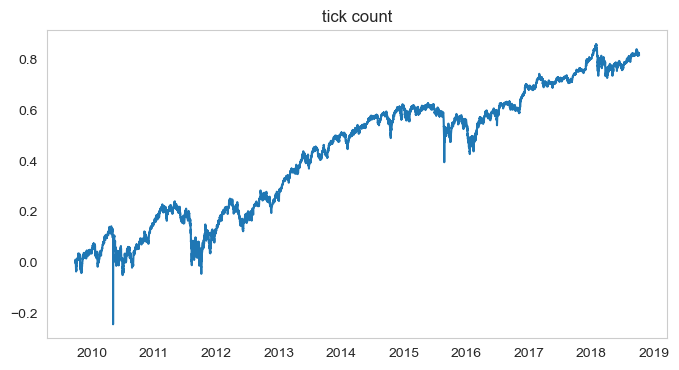

In [53]:
plt.figure(figsize = (8,4))
plt.plot(tick_ret.cumsum())
plt.grid(False)
plt.title('tick count')

Text(0.5, 1.0, 'volume count')

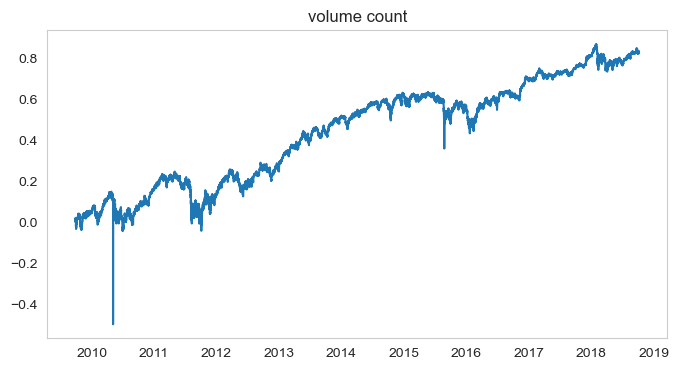

In [54]:
plt.figure(figsize = (8,4))
plt.plot(volume_ret.cumsum())
plt.grid(False)
plt.title('volume count')

Text(0.5, 1.0, 'dollar value count')

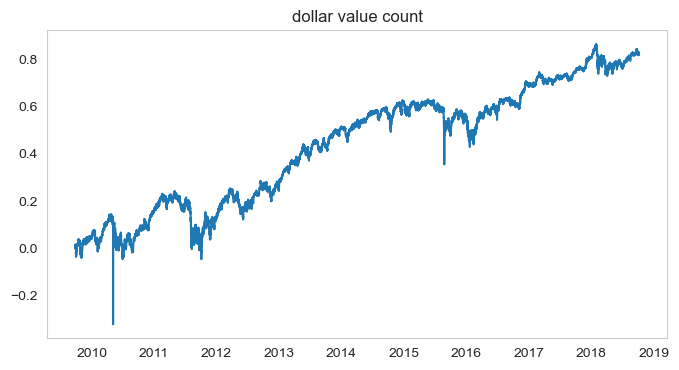

In [55]:
plt.figure(figsize = (8,4))
plt.plot(dollar_ret.cumsum())
plt.grid(False)
plt.title('dollar value count')

Sampling된 plot을 보면, 거의 차이가 없는 것을 볼 수 있다. 즉, Sampling 방법이 타당하다는 것을 알 수 있다